# Fast Gradient Sign Attack (FGSM)
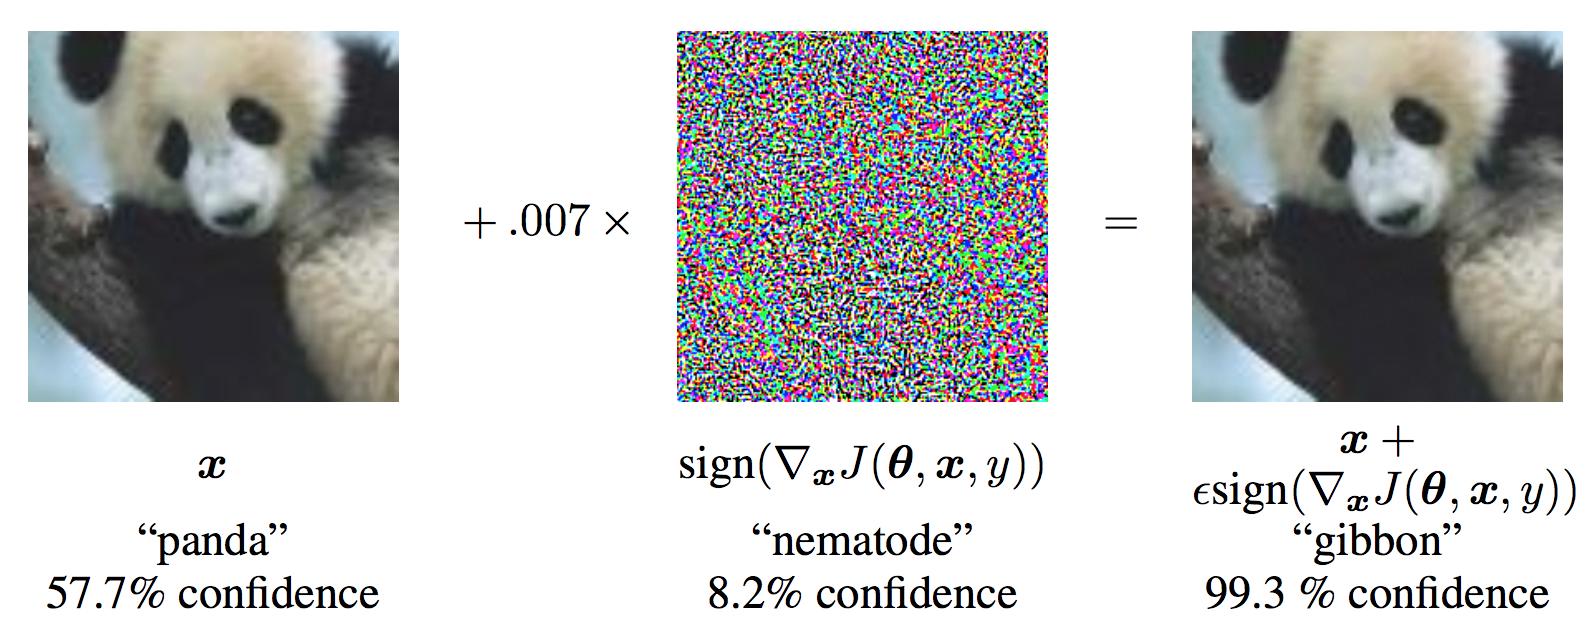
reference: Lan, et al. Explaining and Harnessing Adversarial Examples, ICLR, 2015.

In [1]:
## Installing corresponding python packages & downloading model weights
# !pip install torch requests Pillow transformers matplotlib
# !cd model_weights
# !git lfs install
# !git clone https://hf-mirror.com/Salesforce/blip-image-captioning-base

In [2]:
import torch
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
import matplotlib.pyplot as plt

/home/ll_25113060022/anaconda3/envs/undergraduates_attack_blip/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ll_25113060022/anaconda3/envs/undergraduates_attack_blip/lib/python3.10/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


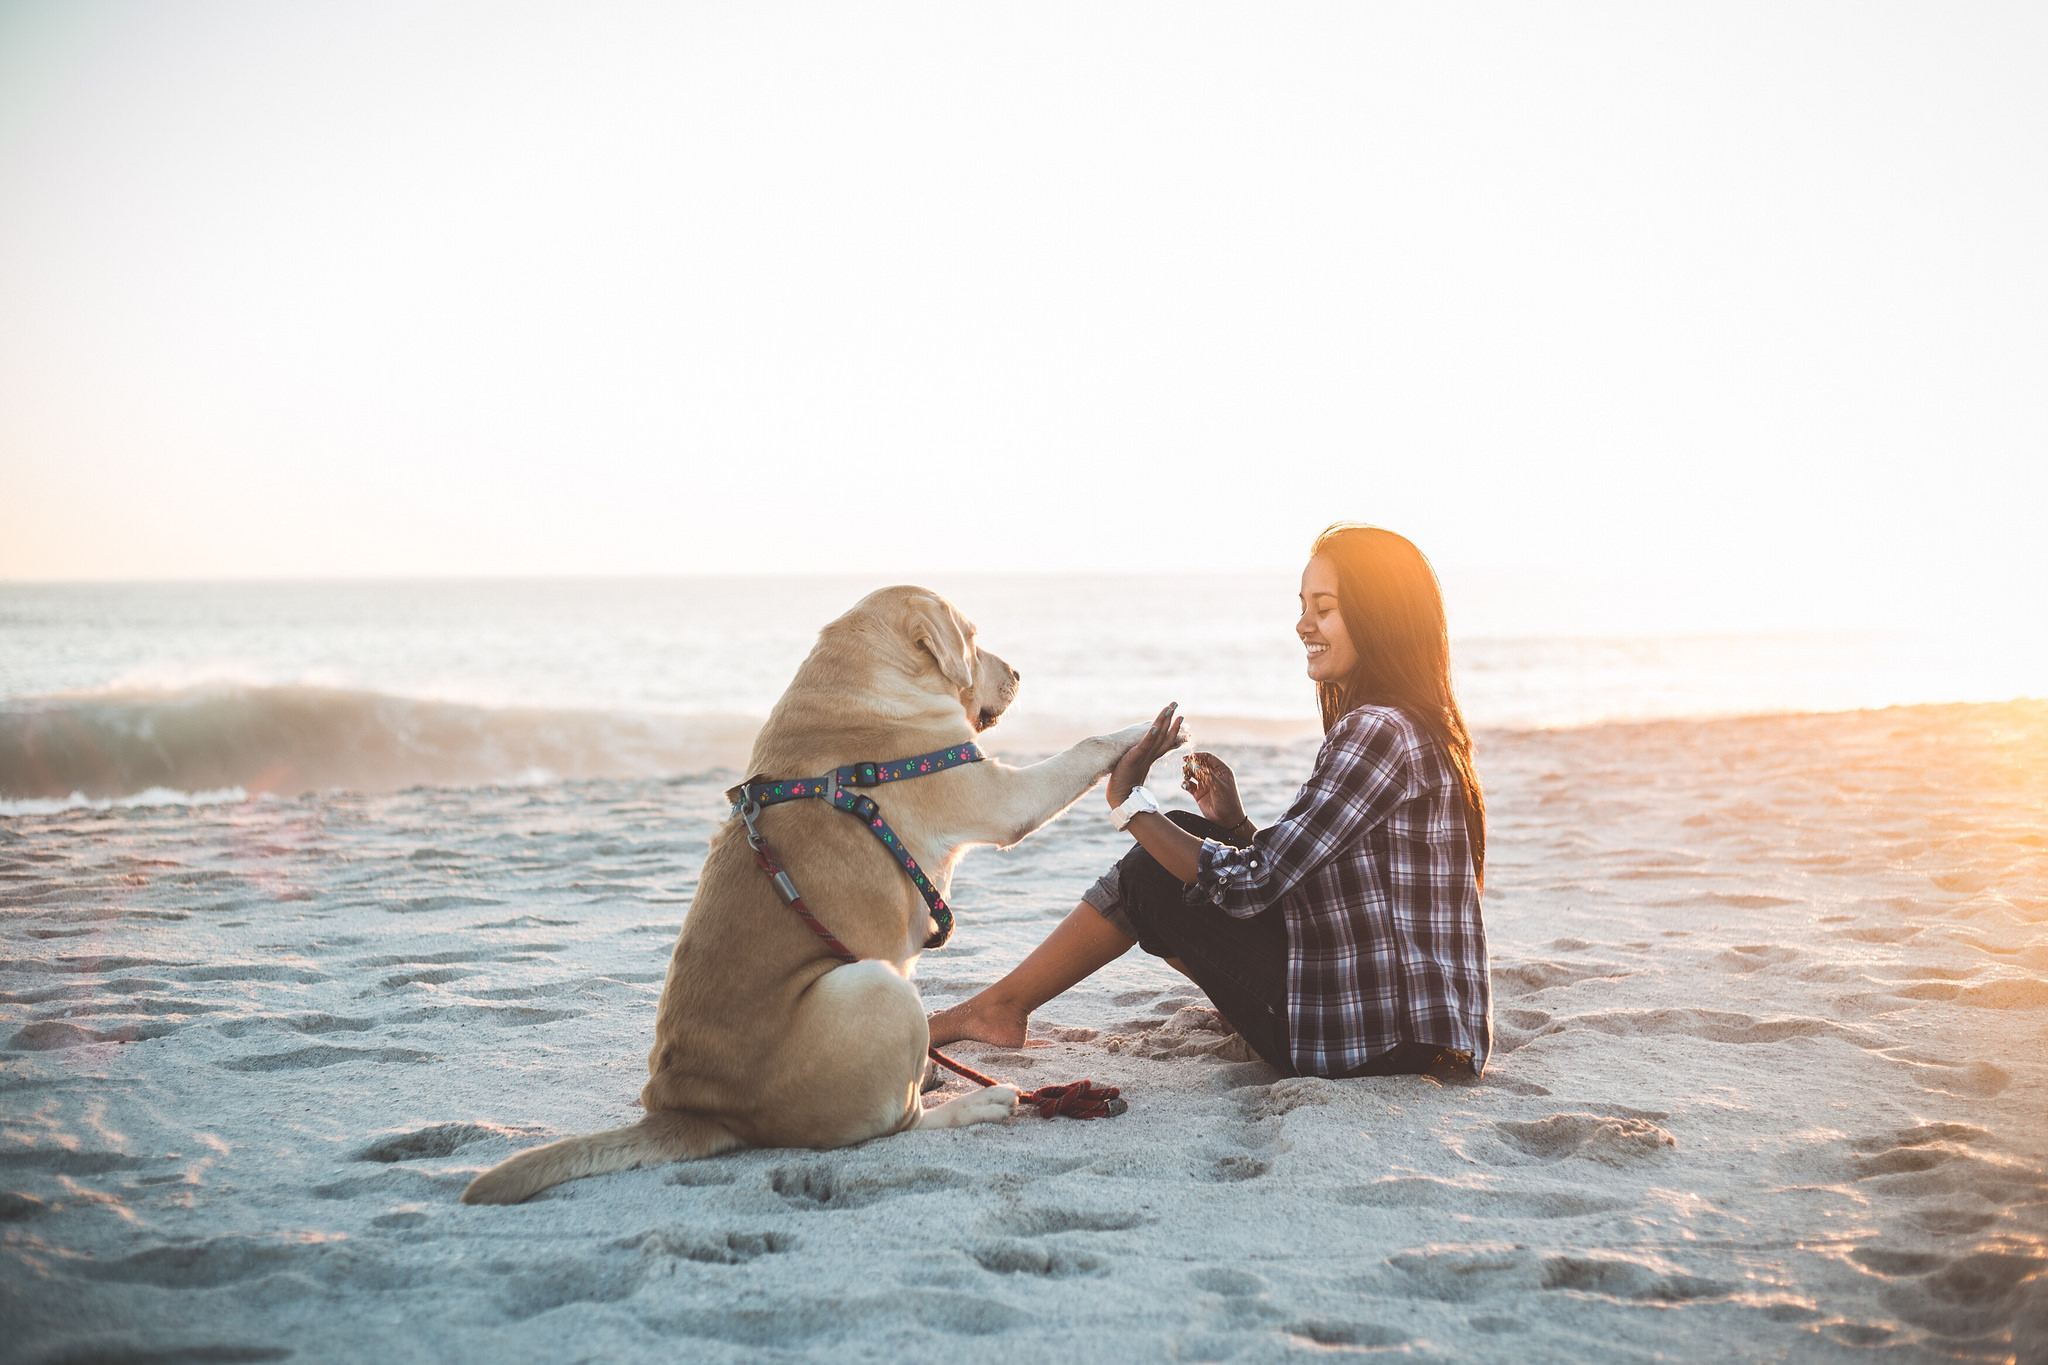

In [3]:
# 设置设备
device = "cuda" if torch.cuda.is_available() else "cpu"

# 加载模型和处理器
model_name = "/cpfs01/projects-HDD/cfff-906dc71fafda_HDD/ll_25113060022/undergraduates_course_copy/adversarial_attack/advanced/model_weights/blip-image-captioning-base"
processor = BlipProcessor.from_pretrained(model_name)
model = BlipForConditionalGeneration.from_pretrained(model_name).to(device)
model.eval()  # 设置为评估模式

# 下载示例图像
url = "https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg"
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')
display(image)  # 显示原始图像

In [4]:
# 预处理图像
def preprocess_image(image):
    inputs = processor(images=image, return_tensors="pt")
    return inputs.pixel_values.to(device)

image_tensor = preprocess_image(image).requires_grad_(True)

# 设置文本提示
text_prompt = "a photography of"
text_inputs = processor(text=text_prompt, return_tensors="pt").to(device)

input_ids = text_inputs.input_ids
with torch.no_grad():
    original_output = model.generate(
            pixel_values=image_tensor, 
            input_ids=input_ids,
            max_length=50
        )
    original_caption = processor.decode(original_output[0], skip_special_tokens=True)
print(f"the original caption of above figure is: \n{original_caption}")

the original caption of above figure is: 
a photography of a woman and her dog on the beach


In [5]:
# FGSM attack
loss = model(
            pixel_values=image_tensor, 
            input_ids=original_output,
            labels=original_output
        ).loss

model.zero_grad()
loss.backward()
    
# 获取图像梯度
data_grad = image_tensor.grad.data
sign_data_grad = data_grad.sign()

# 应用 FGSM 扰动
epsilon = 0.3
perturbed_image = image_tensor + epsilon * sign_data_grad
    
 # 裁剪到有效范围 (保持归一化空间)
perturbed_image = torch.clamp(perturbed_image, -3.0, 3.0)  # 基于 BLIP 的归一化范围

with torch.no_grad():
        
    # 对抗样本描述
    adversarial_output = model.generate(
            pixel_values=perturbed_image.detach(), 
            input_ids=input_ids,
            max_length=50
        )
    adversarial_caption = processor.decode(adversarial_output[0], skip_special_tokens=True)
print(f"the caption of adversarial attack sample: \n{adversarial_caption}")

the caption of adversarial attack sample: 
a photography of a couple sitting in the sand


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.060587585..1.082733].


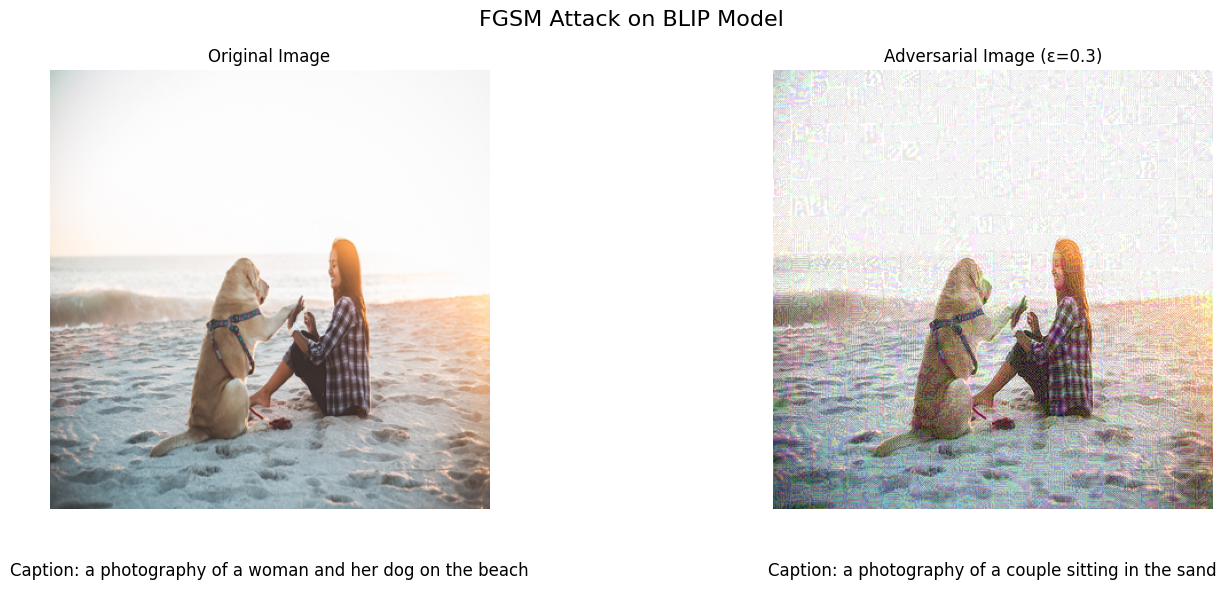

In [6]:
# 反归一化函数（用于可视化）
def denormalize_image(tensor):
    # BLIP 使用的归一化参数：mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711]
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(1, 3, 1, 1).to(device)
    std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(1, 3, 1, 1).to(device)
    return tensor * std + mean

# 可视化结果
def visualize_results(original, perturbed, original_caption, adversarial_caption, title):
    # 反归一化图像用于显示
    original_denorm = denormalize_image(original).squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
    perturbed_denorm = denormalize_image(perturbed).squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
    
    # 创建图表
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(title, fontsize=16)
    
    # 原始图像和描述
    axes[0].imshow(original_denorm)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    axes[0].text(0.5, -0.15, f"Caption: {original_caption}", 
                ha='center', transform=axes[0].transAxes, fontsize=12)
    
    # 对抗样本和描述
    axes[1].imshow(perturbed_denorm)
    axes[1].set_title(f"Adversarial Image (ε={epsilon})")
    axes[1].axis('off')
    axes[1].text(0.5, -0.15, f"Caption: {adversarial_caption}", 
                ha='center', transform=axes[1].transAxes, fontsize=12)
    
    plt.tight_layout()
    plt.show()
# 显示非定向攻击结果
visualize_results(
    image_tensor, 
    perturbed_image, 
    original_caption, 
    adversarial_caption,
    "FGSM Attack on BLIP Model"
)